# Install Packages

In [ ]:
!pip install gym
!pip install pandas
!pip install yfinance
!pip install stable-baselines3
!pip install shimmy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 25.5 MB/s eta 0:00:00


In [ ]:
#별도로 실행할 때 편리하기에 추가한 동일 코드
!pip install yfinance


# Day Trading Via Reinforcement Learning
In the provided code, we're creating a custom reinforcement learning environment for stock trading using Gym, a popular open-source library for developing and comparing reinforcement learning algorithms. Let's break down what the code is doing:

1. We import the required libraries. gym and spaces from Gym are used to create the environment, numpy and pandas for numerical and data frame operations, yfinance to fetch stock market data, and PPO from stable_baselines3 to implement the Proximal Policy Optimization algorithm.
2. We define a custom class StockTradingEnv which inherits from gym.Env. This class simulates a stock trading environment.
3. In the __init__ method, we initialize the state variables, such as the initial balance, the number of shares held, and the dataframes for the stock data.
4. The step method is where the agent takes an action. The action can be either to hold, buy, or sell the stock. The method also calculates the reward which is the change in the asset value after taking the action.
5. The reset method is called at the start of each new episode, resetting the environment to its initial state.
6. The _next_observation method generates the next state based on the current state of the environment.

7. The DummyVecEnv class from stable_baselines3 is used to create a vectorized wrapper for the environment. This is useful for algorithms that require a vector of observations and actions.
8. We initialize a Proximal Policy Optimization (PPO) model with the custom environment and train it for a specified number of timesteps.
9. Finally, we save the trained model using the save method. This model can then be loaded later for further training, evaluation or deployment.

In [ ]:
# 런타임 30초
import gym
from gym import spaces
import numpy as np
import pandas as pd
import yfinance as yf
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

class StockTradingEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, df, pct_df, max_steps=1000):
        super(StockTradingEnv, self).__init__()

        self.df = df
        self.pct_df = pct_df
        self.reward_range = (-np.inf, np.inf)
        self.action_space = spaces.Box(low=np.array([0, 0]), high=np.array([3, 1]), dtype=np.float16)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(5, 5), dtype=np.float16)
        self.initial_balance = 10000
        self.balance = self.initial_balance
        self.shares_held = 0
        self.current_step = 6
        self.max_steps=max_steps
        self.train_cnt_epoch=len(self.df.loc[:, 'Close'].values) - 2-6

    def step(self, action):
      self.current_step += 1

      action_type = action[0]
      amount = action[1]

      # 원저자 코드에 다음 두 줄 뒤에 item()을 추가하여 에러 방지
      close_price = self.df.loc[self.current_step, 'Close'].item()
      next_day_close_price=self.df.loc[self.current_step+1, 'Close'].item()
      # print('current_step ', self.current_step)
      # print('close_price ', close_price)
      # print('next_day_close_price ', next_day_close_price)

      shares_bought = 0
      shares_sold = 0
      asset_value_before_action = self.balance + self.shares_held * close_price

      if action_type < 1:
          # 보유(Hold)
          pass
      elif action_type < 2:
          # 구매(Buy)
          total_possible = int(self.balance / close_price)
          shares_bought = int(total_possible * amount)
          total_cost = shares_bought * close_price
          self.balance -= total_cost
          self.shares_held += shares_bought
      elif action_type < 3:
          # 판매(Sell)
          shares_sold = int(self.shares_held * amount)
          self.balance += shares_sold * close_price
          self.shares_held -= shares_sold

      if self.current_step >= self.train_cnt_epoch:
          self.current_step = 6

      obs = self._next_observation()

      asset_value_after_action = self.balance + self.shares_held * next_day_close_price
      reward = asset_value_after_action - asset_value_before_action
      done = self.current_step >= self.max_steps or self.balance <= 0

      return obs, reward, done, {}

    def reset(self):
        self.balance = self.initial_balance
        self.shares_held = 0
        self.current_step = 6

        return self._next_observation()

    def _next_observation(self):
        end_slice = self.current_step + 1
        start_slice = end_slice-4
        # iloc에 최종 index가 포함되지 않아, 이를 치유하기 위해 end_slice+1 코드 추가
        obs = self.pct_df.iloc[start_slice:end_slice+1].values
        # print(start_slice, ' ', end_slice)
        # print(obs)
        return obs

    def render(self, mode='human'):
        return self.df.loc[self.current_step, 'Open']

    def close(self):
        return

df = yf.download('AAPL', start='2020-01-01', end='2023-01-01')
df = df.sort_values('Date')
df = df.drop(columns='Adj Close')
df = df.reset_index(drop=True)
pct_df = df.copy()

for feature in ['Open', 'High', 'Low', 'Close', 'Volume']:
    pct_df[feature] = pct_df[feature].pct_change()

print(df.head(20))
print(pct_df.head(20))
env = DummyVecEnv([lambda: StockTradingEnv(df, pct_df)])

model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)

model.save("ppo_stock")


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float16
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Price       Close       High        Low       Open     Volume
Ticker       AAPL       AAPL       AAPL       AAPL       AAPL
0       75.087502  75.150002  73.797501  74.059998  135480400
1       74.357498  75.144997  74.125000  74.287498  146322800
2       74.949997  74.989998  73.187500  73.447502  118387200
3       74.597504  75.224998  74.370003  74.959999  108872000
4       75.797501  76.110001  74.290001  74.290001  132079200
5       77.407501  77.607498  76.550003  76.809998  170108400
6       77.582497  78.167503  77.062500  77.650002  140644800
7       79.239998  79.267502  77.787498  77.910004  121532000
8       78.169998  79.392502  78.042503  79.175003  161954400
9       77.834999  78.875000  77.387497  77.962502  121923600
10      78.809998  78.925003  78.022499  78.397499  108829200
11      79.682503  79.684998  78.750000  79.067497  137816400
12      79.142502  79.754997  79.000000  79.297501  110843200
13      79.425003  79.997498  79.327499  79.644997  101832400
14      

# Declaring Environment for Inference
Creating a separate environment for inference (or testing) is a common practice in reinforcement learning for a few reasons:
1. Different End Conditions: You might notice that the end condition (the done variable) in the test environment is different from the training environment. In the training environment, an episode might end when the balance drops to zero. However, in the test environment, we might want to run the episode for a fixed number of steps, regardless of the balance. This allows us to fully evaluate the model's performance over a complete episode.
2. In the provided StockTradingTestEnv, it inherits from StockTradingEnv but overrides the step method to provide a different end condition and potentially other differences suitable for inference/testing. The method of creating a separate environment for testing ensures that the model is evaluated in a way that's independent of its training, giving a more reliable assessment of its ability to handle new data or scenarios.

In [ ]:
class StockTradingTestEnv(StockTradingEnv):
    def __init__(self, df, pct_df, initial_balance=10000):
        super().__init__(df, pct_df)
        self.initial_balance = initial_balance
        self.balance = self.initial_balance
        self.train_cnt_epoch=len(self.df.loc[:, 'Close'].values) - 2-6

    def step(self, action):
        self.current_step += 1
        action_type = action[0]
        amount = action[1]

        # 원저자 코드에 다음 두 줄 뒤에 item()을 추가하여 에러 방지
        close_price = self.df.loc[self.current_step, 'Close'].item()
        next_day_close_price=self.df.loc[self.current_step+1, 'Close'].item()

        shares_bought = 0
        shares_sold = 0
        asset_value_before_action = self.balance + self.shares_held * close_price

        if action_type < 1:
            # 보유(Hold)
            pass
        elif action_type < 2:
            # 구매(Buy)
            total_possible = int(self.balance / close_price)
            shares_bought = int(total_possible * amount)
            total_cost = shares_bought * close_price
            self.balance -= total_cost
            self.shares_held += shares_bought
        elif action_type < 3:
            # 판매(Sell)
            shares_sold = int(self.shares_held * amount)
            self.balance += shares_sold * close_price
            self.shares_held -= shares_sold

        if self.current_step >= len(self.df.loc[:, 'Close'].values) - 6:
            self.current_step = 6

        obs = self._next_observation()

        asset_value_after_action = self.balance + self.shares_held * next_day_close_price
        reward = asset_value_after_action - asset_value_before_action


        if self.current_step >= self.train_cnt_epoch:
          done = True
        else:
          done = False

        return obs, reward, done, {}


# Inference
This code block is performing inference or testing on a trained PPO model for stock trading. Here's what the code is doing:
1. Loading the Trained Model
2. Downloading and Preprocessing New Dataset
3.Setting Up Testing Environment: A new testing environment, StockTradingTestEnv, is initialized with the new data and final balance from training. The environment is wrapped with DummyVecEnv which is a simple vectorized wrapper for multiple environments, this makes it compatible with Stable Baselines' models.
4. Running the Model: An initial state of the environment is set and the environment is run until it reaches the end. In each step, the model predicts the next action based on the current state. This action is then passed to the environment through the step function which returns the new state, reward, whether the episode is done, and other info. If the episode is not done, the current portfolio value (the balance plus the current value of held shares) is calculated and stored in the portfolio_values list. This continues until all the new data is used.
5. Plotting Portfolio Value: Finally, a plot is created to show how the value of the portfolio changes over time. The x-axis is the step number and the y-axis is the portfolio value.


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float16
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Reached the end of the data.


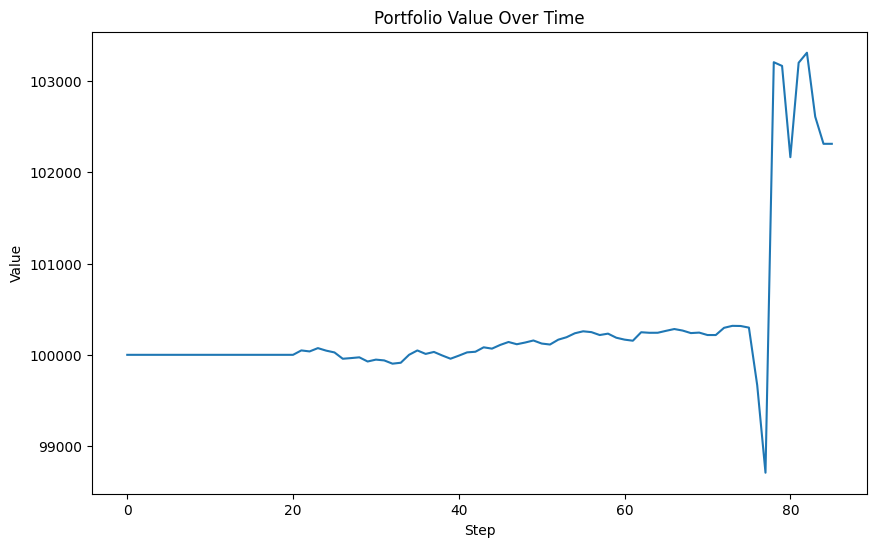

In [ ]:
import matplotlib.pyplot as plt
from stable_baselines3 import PPO

# 저장된 모델 불러오기
model = PPO.load("ppo_stock.zip")

# 새 데이터셋 불러오기
df_2023 = yf.download('AAPL', start='2023-01-01', end='2023-05-30')
df_2023 = df_2023.sort_values('Date')
df_2023 = df_2023.drop(columns='Adj Close')
df_2023 = df_2023.reset_index(drop=True)

# 새로운 데이터프레임 생성
pct_df_2023 = df_2023.copy()

for feature in ['Open', 'High', 'Low', 'Close', 'Volume']:
    pct_df_2023[feature] = pct_df_2023[feature].pct_change()

# 새 데이터용 환경 설정 및 (학습에서 얻은) final balance 조정
final_training_balance = 100000
env = DummyVecEnv([lambda: StockTradingTestEnv(df_2023, pct_df_2023, initial_balance=final_training_balance)])

# 환경의 초기 상태 설정
initial_state = env.reset()
done = False

# 이 리스트는 각 스텝(step)에서 포트폴리오의 값을 저장
portfolio_values = []

while not done:
    # 모델(model)로부터 action 구하기
    action, _ = model.predict(initial_state)
    # print('printing action')
    # print(action)

    # 환경에서 첫 스텝을 실행하고 새로운 상태(state)와 보상(reward) 구하기
    initial_state, reward, done, info = env.step(action)
    # 포트폴리오 현재 값은 초기화된 balance와 shares_held를 합한 값임

    if not done:
        portfolio_value = env.envs[0].balance + (env.envs[0].shares_held * env.envs[0].df.loc[env.envs[0].current_step, 'Close'])
        # print('balance', env.envs[0].balance)
        # print('shares_held', env.envs[0].shares_held)
        # print('portfolio_value', portfolio_value)
        # 포트폴리오 값을 리스트에 추가
        portfolio_values.append(portfolio_value)
        # print('portfolio_values', portfolio_values)
        # print('current_step', env.envs[0].current_step)
    else:
        print("Reached the end of the data.")


# 시간에 걸친 포트폴리오 값 디스플레이
plt.figure(figsize=(10,6))
plt.plot(portfolio_values)
plt.title('Portfolio Value Over Time')
plt.xlabel('Step')
plt.ylabel('Value')
plt.show()


# Let's Check if the model still works for another type of stock

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float16
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Reached the end of the data.


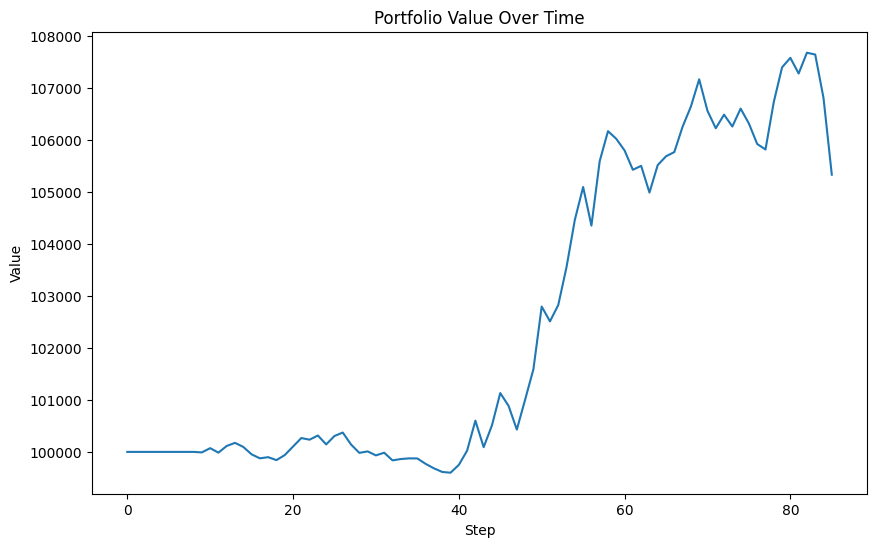

In [ ]:
import matplotlib.pyplot as plt
from stable_baselines3 import PPO

# 저장된 모델 불러오기
model = PPO.load("ppo_stock.zip")

# 새 데이터셋 불러오기
df_2023 = yf.download('WMT', start='2023-01-01', end='2023-05-30')
df_2023 = df_2023.sort_values('Date')
df_2023 = df_2023.drop(columns='Adj Close')
df_2023 = df_2023.reset_index(drop=True)

# 새로운 데이터프레임 생성
pct_df_2023 = df_2023.copy()

for feature in ['Open', 'High', 'Low', 'Close', 'Volume']:
    pct_df_2023[feature] = pct_df_2023[feature].pct_change()

# 새 데이터용 환경 설정 및 (학습에서 얻은) final balance 조정
final_training_balance = 100000
env = DummyVecEnv([lambda: StockTradingTestEnv(df_2023, pct_df_2023, initial_balance=final_training_balance)])

# 환경의 초기 상태 설정
initial_state = env.reset()
done = False

# 이 리스트는 각 스텝(step)에서 포트폴리오의 값을 저장
portfolio_values = []

while not done:
    # 모델(model)로부터 action 구하기
    action, _ = model.predict(initial_state)
    # print('printing action')
    # print(action)

    # 환경에서 첫 스텝을 실행하고 새로운 상태(state)와 보상(reward) 구하기
    initial_state, reward, done, info = env.step(action)
    # 포트폴리오 현재 값은 초기화된 balance와 shares_held를 합한 값임

    if not done:
        portfolio_value = env.envs[0].balance + (env.envs[0].shares_held * env.envs[0].df.loc[env.envs[0].current_step, 'Close'])
        # print('balance', env.envs[0].balance)
        # print('shares_held', env.envs[0].shares_held)
        # print('portfolio_value', portfolio_value)
        # 포트폴리오 값을 리스트에 추가
        portfolio_values.append(portfolio_value)
        # print('portfolio_values', portfolio_values)
        # print('current_step', env.envs[0].current_step)
    else:
        print("Reached the end of the data.")


# 시간에 걸친 포트폴리오 값 디스플레이
plt.figure(figsize=(10,6))
plt.plot(portfolio_values)
plt.title('Portfolio Value Over Time')
plt.xlabel('Step')
plt.ylabel('Value')
plt.show()
